# Baseline model

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn import tree, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# Set random seed for reproducibility
SEED = 42

In [3]:
# Load the data
df = pd.read_csv('../data/interim/FibroPredCODIFICADA.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 77 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Pedigree                                       222 non-null    int64  
 1   Sex                                            222 non-null    object 
 2   FamilialvsSporadic                             222 non-null    object 
 3   COD NUMBER                                     222 non-null    object 
 4   Age at diagnosis                               221 non-null    float64
 5   Binary diagnosis                               222 non-null    object 
 6   Final diagnosis                                222 non-null    int64  
 7   TOBACCO                                        222 non-null    int64  
 8   Detail                                         66 non-null     object 
 9   Comorbidities                                  222 non

## 1. Define the columns to use

First, define the columns we are going to use for the model.

In [4]:
columns = [
    'TOBACCO',  # Tabaquisme
    'Age at diagnosis',  # Edat
    'Type of family history',  # Tipus de MPID
    'FamilialvsSporadic',  # Agregació familiar
    'FVC (%) at diagnosis',  # % FVC o DLCO al diagnostic
    'Identified Infection',  # Aguditzacions o infeccions respiratòries
    'Comorbidities',  # Comorbiditats
    'Genetic mutation studied in patient',  # Existència de variants genètiques patogèniques (mutacions)
    'Severity of telomere shortening',  # Escurçament telomèric
    'Radiological Pattern'  # Patró NIU al TCAR tórax o histologia
]

df_reduced = df[columns]

Separate the columns into two groups: numerical and categorical.

In [5]:
categorical_columns = [
    'TOBACCO',
    'Type of family history',
    'FamilialvsSporadic',
    'Identified Infection',
    'Comorbidities',
    'Genetic mutation studied in patient',
    'Severity of telomere shortening',
    'Radiological Pattern'
]
numerical_columns = [column for column in columns if column not in categorical_columns]

## 2. Preprocessing
Fill missing values, encode categorical columns, and scale numerical columns.

In [6]:
# Check for missing values
print(df_reduced.isnull().sum())

TOBACCO                                  0
Age at diagnosis                         1
Type of family history                   1
FamilialvsSporadic                       0
FVC (%) at diagnosis                     2
Identified Infection                   216
Comorbidities                            0
Genetic mutation studied in patient     20
Severity of telomere shortening         70
Radiological Pattern                     1
dtype: int64


In [7]:
# Replace missing values with a new category for categorical columns, and with the mean for numerical columns
for column in categorical_columns:
    df_reduced[column] = df_reduced[column].fillna('Unknown')
    
for column in numerical_columns:
    df_reduced[column] = df_reduced[column].fillna(df_reduced[column].mean())

/var/folders/r8/b4mx683j1yd1x7__0g3qs49m0000gn/T/ipykernel_96707/2768108047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[column] = df_reduced[column].fillna('Unknown')
/var/folders/r8/b4mx683j1yd1x7__0g3qs49m0000gn/T/ipykernel_96707/2768108047.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[column] = df_reduced[column].fillna(df_reduced[column].mean())


In [8]:
print(df_reduced.isnull().sum())

TOBACCO                                0
Age at diagnosis                       0
Type of family history                 0
FamilialvsSporadic                     0
FVC (%) at diagnosis                   0
Identified Infection                   0
Comorbidities                          0
Genetic mutation studied in patient    0
Severity of telomere shortening        0
Radiological Pattern                   0
dtype: int64


In [9]:
# Convert categorical columns to dummies
df_reduced = pd.get_dummies(df_reduced, columns=categorical_columns)
print(df_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 66 columns):
 #   Column                                                                                           Non-Null Count  Dtype  
---  ------                                                                                           --------------  -----  
 0   Age at diagnosis                                                                                 222 non-null    float64
 1   FVC (%) at diagnosis                                                                             222 non-null    float64
 2   TOBACCO_0                                                                                        222 non-null    bool   
 3   TOBACCO_1                                                                                        222 non-null    bool   
 4   TOBACCO_2                                                                                        222 non-null    bool   
 5   Type of 

In [10]:
# Normalize numerical columns
scaler = StandardScaler()

df_reduced[numerical_columns] = scaler.fit_transform(df_reduced[numerical_columns])
print(df_reduced.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 66 columns):
 #   Column                                                                                           Non-Null Count  Dtype  
---  ------                                                                                           --------------  -----  
 0   Age at diagnosis                                                                                 222 non-null    float64
 1   FVC (%) at diagnosis                                                                             222 non-null    float64
 2   TOBACCO_0                                                                                        222 non-null    bool   
 3   TOBACCO_1                                                                                        222 non-null    bool   
 4   TOBACCO_2                                                                                        222 non-null    bool   
 5   Type of 

## 3. Model selection
Try multiple models to check the best one for the dataset.

Decision Tree accuracy: 0.625
MLP accuracy: 0.625
Random Forest accuracy: 0.6875
SVM accuracy: 0.65625
                                        Feature  Importance
1                          FVC (%) at diagnosis    0.195212
0                              Age at diagnosis    0.155674
50      Genetic mutation studied in patient_0.0    0.051122
41                  FamilialvsSporadic_Sporadic    0.042995
56          Severity of telomere shortening_3.0    0.036834
..                                          ...         ...
35  Type of family history_SRIF, unspecified PF    0.000000
38  Type of family history_Unspecified PF, IPAF    0.000000
39  Type of family history_Unspecified PF, SRIF    0.000000
49     Genetic mutation studied in patient_-9.0    0.000000
65                 Radiological Pattern_Unknown    0.000000

[66 rows x 2 columns]


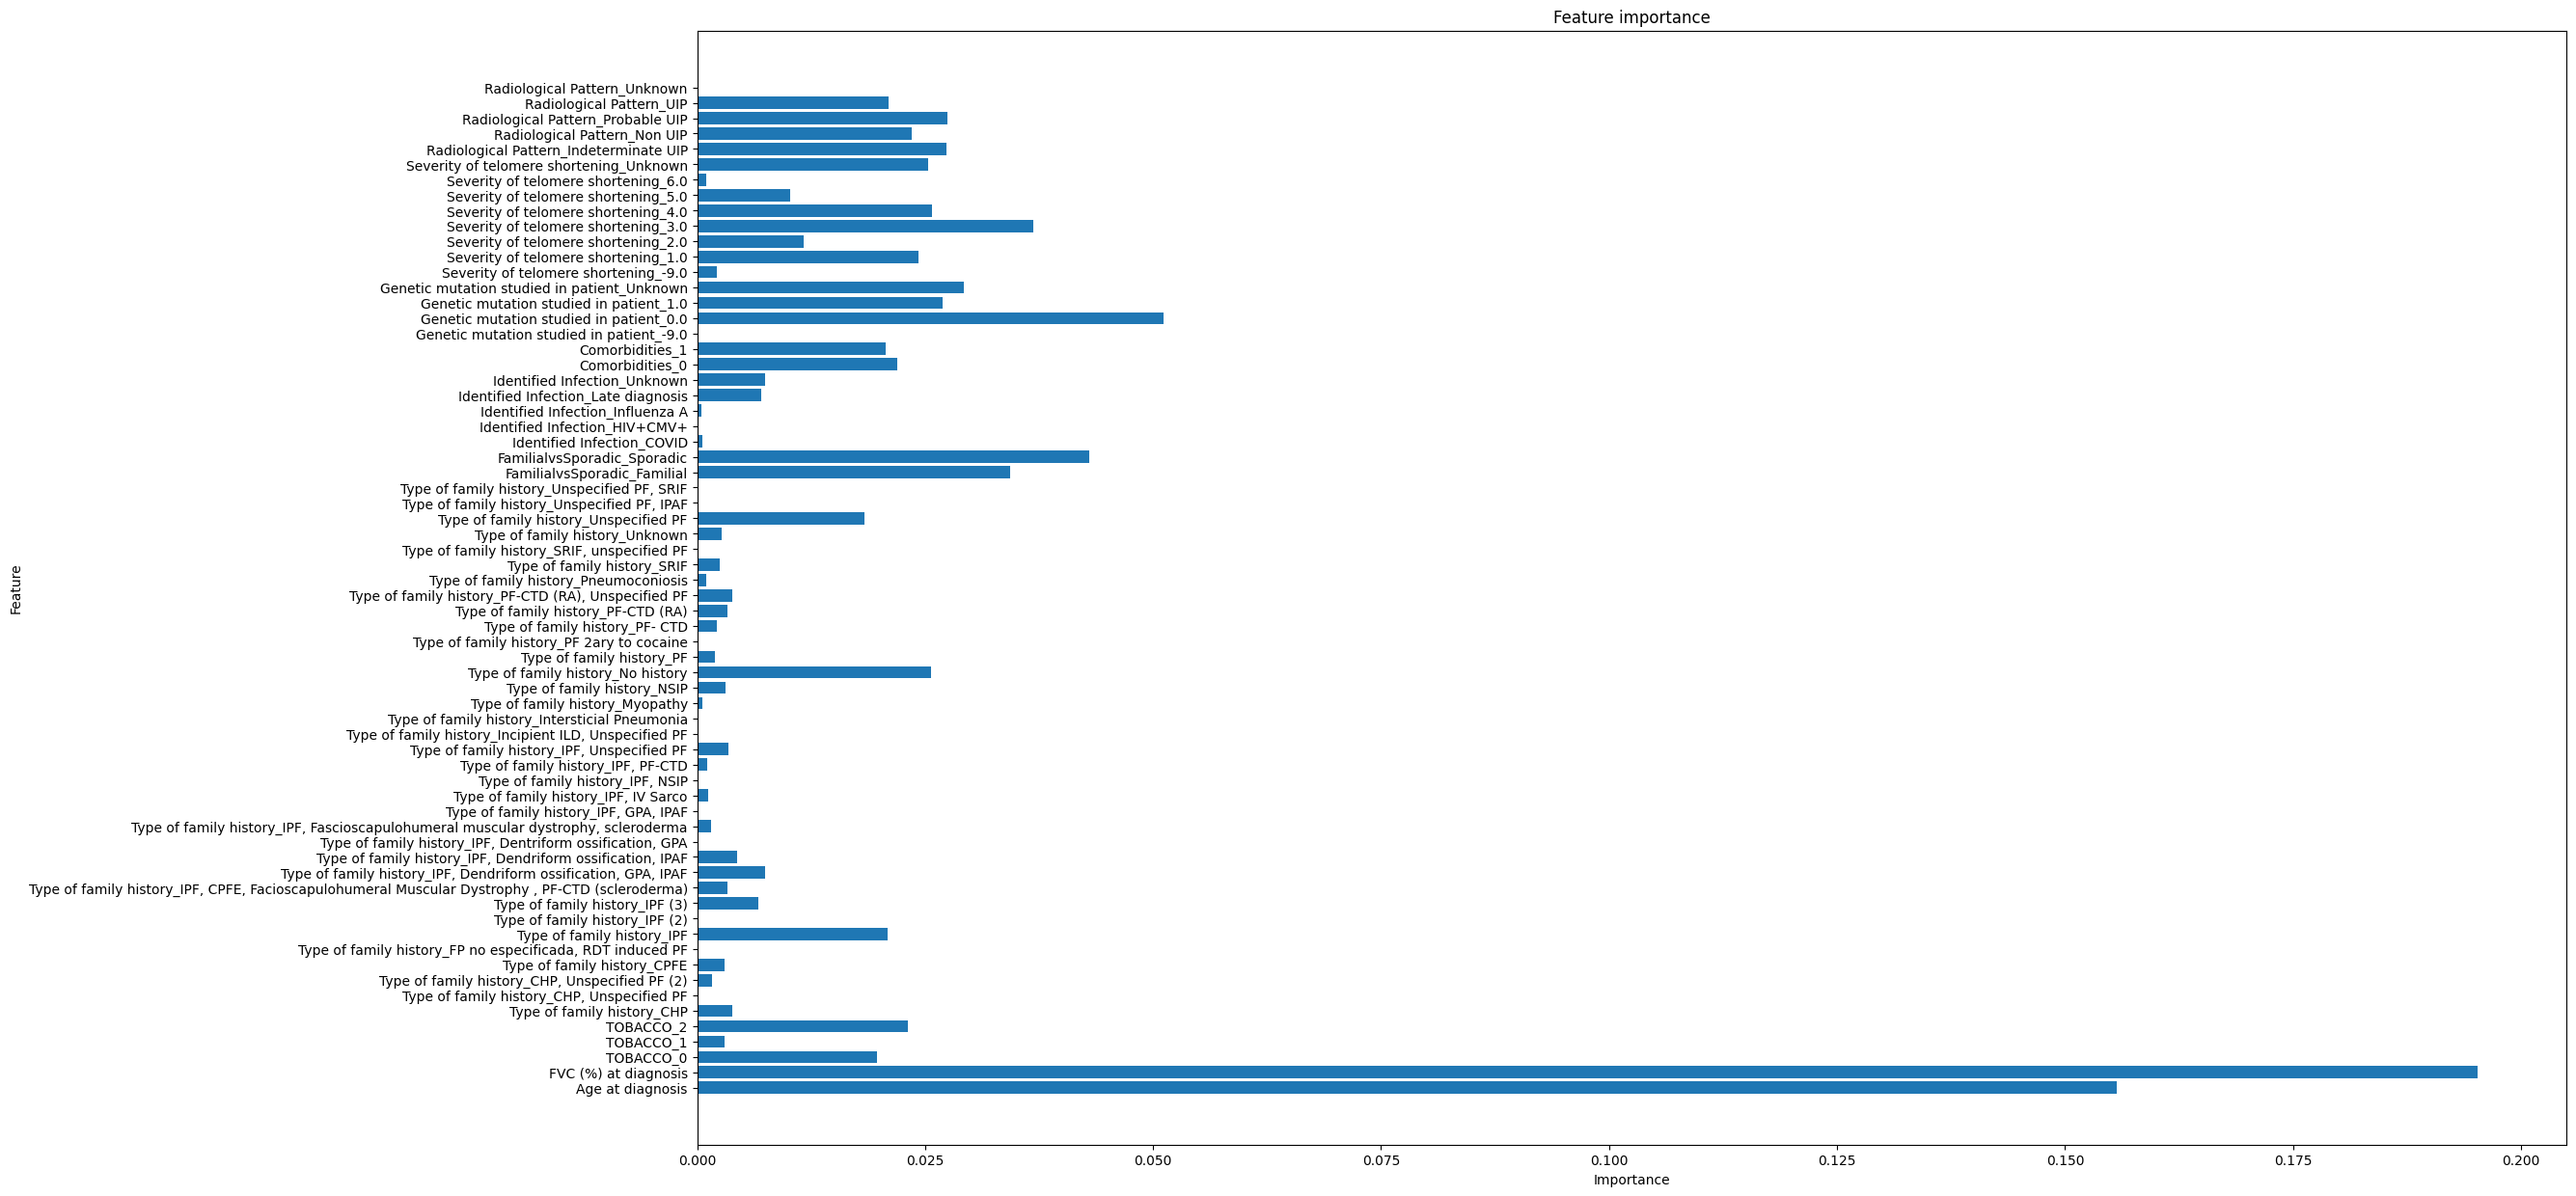

In [11]:
# Drop rows where the target is missing
df_reduced = df_reduced[df['ProgressiveDisease'].notnull()]

# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_reduced, df['ProgressiveDisease'][df['ProgressiveDisease'].notnull()], test_size=0.3, random_state=42)

# Train the models
models = {
    'Decision Tree': tree.DecisionTreeClassifier(random_state=SEED),
    'MLP': MLPClassifier(random_state=SEED, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'SVM': svm.SVC(random_state=SEED)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{model_name} accuracy: {accuracy_score(y_test, y_pred)}')
    
# Check the importance of each feature for the Random Forest model
importances = models['Random Forest'].feature_importances_
features = X_train.columns
importances_df = pd.DataFrame({'Feature': features, 'Importance': importances})
print(importances_df.sort_values(by='Importance', ascending=False))

# Plot the importance of each feature for the Random Forest model
fig = plt.figure(figsize=(25, 15))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature importance')
plt.show()

In [12]:
# Do the same as before but using k-fold cross validation
from sklearn.model_selection import cross_val_score

for model_name, model in models.items():
    scores = cross_val_score(model, df_reduced, df['ProgressiveDisease'][df['ProgressiveDisease'].notnull()], cv=10)
    print(f'{model_name} accuracy: {scores.mean()}')

Decision Tree accuracy: 0.6515151515151515
MLP accuracy: 0.6090909090909091
Random Forest accuracy: 0.6474025974025974
SVM accuracy: 0.6240259740259739


## 4. Try multiple datasets and multiple models

In [13]:
import os
from sklearn.metrics import confusion_matrix

from preprocessing import preprocess_data


data_path = '../data/interim/'

# For each dataset, preprocess it and train the models.
accuracies = []
confusion_matrices = []

for file in os.listdir(data_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path, file))
        df, _ = preprocess_data(df)
        
        target_column = 'target' if 'target' in df.columns else 'ProgressiveDisease'
        
        for model_name, model in models.items():
            scores = cross_val_score(model, df, df[target_column], cv=10)
            accuracies.append(scores.mean())
            
            model.fit(df, df[target_column])
            y_pred = model.predict(df)
            confusion_matrices.append(confusion_matrix(df[target_column], y_pred))
        
        # 10-fold cross validation
        scores = cross_val_score(models['Random Forest'], df, df[target_column], cv=10)
        accuracies.append(scores.mean())
        
        # Train the model
        models['Random Forest'].fit(df, df[target_column])
        y_pred = models['Random Forest'].predict(df)
        confusion_matrices.append(confusion_matrix(df[target_column], y_pred))
        
print(accuracies)
print(confusion_matrices)

[1.0, 0.9391774891774892, 1.0, 0.9525974025974027, 1.0, 1.0, 0.8606719367588933, 0.9954545454545455, 0.9644268774703558, 0.9954545454545455, 1.0, 0.9339826839826841, 1.0, 0.9525974025974027, 1.0, 1.0, 0.9251082251082252, 0.9952380952380953, 0.9621212121212122, 0.9952380952380953, 1.0, 0.9203463203463202, 1.0, 0.9525974025974027, 1.0]
[array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[125,   0],
       [  0,  97]]), array([[125,   0],
       [  0,  97]]), array([[125,   0],
       [  0,  97]]), array([[125,   0],
       [  0,  97]]), array([[125,   0],
       [  0,  97]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
       [  0, 100]]), array([[112,   0],
    

## 5. Train the best performing model and save it for inference

Train each model with one dataset, using all the data, and save the model, the scaler, and the columns information into a `/models/dataset` folder.

In [17]:
import joblib
import json

from preprocessing import get_columns_info

# Get time to append to output folder
from datetime import datetime

now = datetime.now()
time = now.strftime("%Y-%m-%d_%H-%M-%S")


# Train the models with the best dataset
dataset_name = 'with_all_indicators'
df = pd.read_csv(f'../data/interim/{dataset_name}.csv')
df, scaler = preprocess_data(df)

target_column = 'target' if 'target' in df.columns else 'ProgressiveDisease'

output_folder = f'../output_{time}/{dataset_name}'

for model_name, model in models.items():
    # Train the model
    model.fit(df, df[target_column])
    y_pred = model.predict(df)
    print(f'{model_name} accuracy: {accuracy_score(df[target_column], y_pred)}')
    
    # Create a folder to save the model and columns information
    model_folder = f'{output_folder}/{model_name}'
    os.makedirs(model_folder, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(model_folder, 'model.sav')
    joblib.dump(model, model_path)
    
    # Save the columns information
    columns_info = get_columns_info(df)
    columns_info_path = os.path.join(model_folder, 'columns_info.json')
    
    with open(columns_info_path, 'w') as f:
        json.dump(columns_info, f)
        
# Save the scaler
scaler_path = f'{output_folder}/scaler.sav'
joblib.dump(scaler, scaler_path)


Decision Tree accuracy: 1.0
MLP accuracy: 1.0
Random Forest accuracy: 1.0
SVM accuracy: 1.0


['../output_2024-12-14_19-48-44/with_all_indicators/scaler.sav']